Exploratory Data Analysis - Jupyter Notebook
================================================

This jupyter notebook contains the results of the Exploratory Data Analysis (EDA).

Ideas are taken from the book:  
Mukhiya, S. K., & Ahmed, U. (2020). Hands-On Exploratory Data Analysis with Python: Perform EDA Techniques to Understand, Summarize, and Investigate Your Data. Packt Publishing.


## Loading the Data

In [1011]:
# Operating system functionalities to join pathname components
import os
# Pandas for DataFrame and CSV handling
import pandas as pd

# Join the filepath of the raw data file
filepath = os.path.join("..", "..", "..", "data", "raw", "sickness_table.csv")
print("### Load Data ### Filepath: ", filepath)

# Read the data from CSV file
data_raw = pd.read_csv(filepath)
print("### Load Data ### Structure (first 5 rows): \n", data_raw.head(5))

### Load Data ### Filepath:  ../../../data/raw/sickness_table.csv
### Load Data ### Structure (first 5 rows): 
    Unnamed: 0        date  n_sick   calls  n_duty  n_sby  sby_need  dafted
0           0  2016-04-01      73  8154.0    1700     90       4.0     0.0
1           1  2016-04-02      64  8526.0    1700     90      70.0     0.0
2           2  2016-04-03      68  8088.0    1700     90       0.0     0.0
3           3  2016-04-04      71  7044.0    1700     90       0.0     0.0
4           4  2016-04-05      63  7236.0    1700     90       0.0     0.0


It is therefore structured tiem series data, with the following columns:
- (unnamed): Row number
- date: Date
- n_sick: Number of emergency drivers who have registered a sick call
- calls: Number of emergency calls
- n_duty: Number of emergency drivers on duty
- n_sby: Number of available substitute drivers
- sby_need: Number of substitute drivers to be activated
- dafted: Number of additional duty drivers that have to be activated if the number of on-call drivers are not sufficient

## Data Structure Overview

At first, get an overview about the data structure.

### Data Types

In [1012]:
# Get the data types of the columns
print("### Data Overview ### Data types: \n",data_raw.dtypes)

### Data Overview ### Data types: 
 Unnamed: 0      int64
date           object
n_sick          int64
calls         float64
n_duty          int64
n_sby           int64
sby_need      float64
dafted        float64
dtype: object


The columns contain either integer or float values.

## Data Conversions
### Date

The date field is an object, so we need to convert it into a DateTime argument (Mukhiya & Ahmed, 2020, p. 76).

In [1013]:
# Copy the data for conversion into a new variable
data = data_raw.copy()
# Convert the date objects into DateTime (raise an exception when parsing is invalid)
data.date = data.date.apply(lambda x: pd.to_datetime(x,
errors='raise', utc=True))
print("### Data Conversion ### First 5 rows after convert date: \n", data.head(5))
# Get the data types of the columns again
print("### Data Conversion ### Data types after convert date: \n",data.dtypes)

### Data Conversion ### First 5 rows after convert date: 
    Unnamed: 0                      date  n_sick   calls  n_duty  n_sby  \
0           0 2016-04-01 00:00:00+00:00      73  8154.0    1700     90   
1           1 2016-04-02 00:00:00+00:00      64  8526.0    1700     90   
2           2 2016-04-03 00:00:00+00:00      68  8088.0    1700     90   
3           3 2016-04-04 00:00:00+00:00      71  7044.0    1700     90   
4           4 2016-04-05 00:00:00+00:00      63  7236.0    1700     90   

   sby_need  dafted  
0       4.0     0.0  
1      70.0     0.0  
2       0.0     0.0  
3       0.0     0.0  
4       0.0     0.0  
### Data Conversion ### Data types after convert date: 
 Unnamed: 0                  int64
date          datetime64[ns, UTC]
n_sick                      int64
calls                     float64
n_duty                      int64
n_sby                       int64
sby_need                  float64
dafted                    float64
dtype: object


## Data Cleaning

### Detect missing values

Identify NaN Values within the pandas dataframe using the isnull() function (Mukhiya & Ahmed, 2020, p. 113).

In [1014]:
# Detect missing values: In each columns
print("### Data Cleaning ### Number of missing values in each column: \n", data.isnull().sum())
# Detect missing values: Total number
print("### Data Cleaning ### Total number of missing values: ", data.isnull().sum().sum())

### Data Cleaning ### Number of missing values in each column: 
 Unnamed: 0    0
date          0
n_sick        0
calls         0
n_duty        0
n_sby         0
sby_need      0
dafted        0
dtype: int64
### Data Cleaning ### Total number of missing values:  0


There are no missing values within the dataset.

### Drop columns

Irrelevant columns can be dropped (Mukhiya & Ahmed, 2020, p. 79).

In [1015]:
# Discover columns that contain only a few different values
data.nunique()

Unnamed: 0    1152
date          1152
n_sick          74
calls          616
n_duty           3
n_sby            1
sby_need       185
dafted         119
dtype: int64

The first column only contains the row number, which is obsolete due to the row indices of the DataFrame and can be removed.  
The column n_sby contains only one particular value, which can be removed in general. However, this is the value to be predicted, so the column should remain to keep the data structure compatible for the future.

In [1016]:
# Drop the column with index 0 (unamed)
data.drop(columns=data.columns[0], inplace=True)
print("### Data Cleaning ### Raw data columns: \n",data_raw.columns)
print("### Data Cleaning ### Cleaned columns: \n",data.columns)


### Data Cleaning ### Raw data columns: 
 Index(['Unnamed: 0', 'date', 'n_sick', 'calls', 'n_duty', 'n_sby', 'sby_need',
       'dafted'],
      dtype='object')
### Data Cleaning ### Cleaned columns: 
 Index(['date', 'n_sick', 'calls', 'n_duty', 'n_sby', 'sby_need', 'dafted'], dtype='object')


The column n_duty contains 3 different values. In what frequency do they occur?

### Data Cleaning ### Set of n_duty: 
 {1800, 1900, 1700}
### Data Cleaning ### Length of the set of n_duty: 
 3


Text(0.5, 1.0, 'Number of emergency drivers on duty')

<Figure size 1500x480 with 0 Axes>

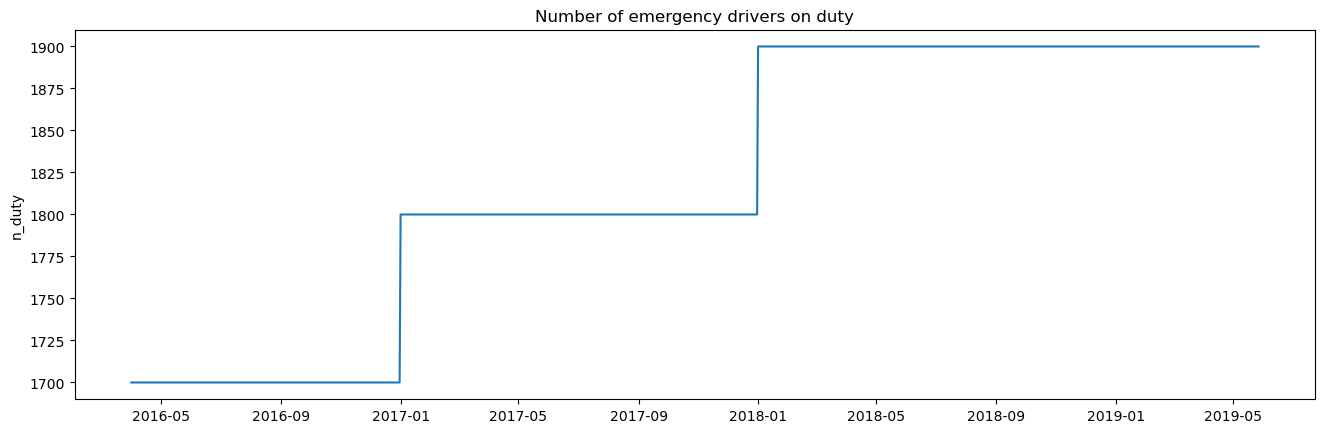

In [1017]:
# Get the set of values witin the column and print the length
n_duty_set = set(data.n_duty)
print("### Data Cleaning ### Set of n_duty: \n",n_duty_set)
n_duty_set_len = len(n_duty_set)
print("### Data Cleaning ### Length of the set of n_duty: \n",n_duty_set_len)

# Plot the distribution
# Matplotlib for plots
import matplotlib.pyplot as plt
plt.figure().set_figwidth(15)
# Create a figure
fig, ax = plt.subplots()
# Set figure width [inch]
fig.set_figwidth(16)
# Plot data
ax.plot(data.date, data.n_duty)
# Set y-label
ax.set_ylabel("n_duty")
# Set title
ax.set_title("Number of emergency drivers on duty")


The number of emergency drivers on duty was increased two times, the column can thus not be removed.

The column dafted contains the number of additional duty drivers that have to be activated if the number of on-call drivers are not sufficient. It can be assumed that this is the difference between sby_need and n_sby if it is positive.

In [1018]:
# Get the rows if the value of the column dafted ist not zero:
data_dafted_rows = data.loc[(data['dafted'] != 0)]
print("### Data Cleaning ### Data rows with values dafted != 0: \n", data_dafted_rows)
# Counter for rows for which the assumption is false (the difference between sby_need and n_sby is equal to dafted in case dafted is not zero)
couter_dafted_is_required = 0
# Counter to check the number of loop passes
counter_loop_passes = 0
for index, row in data_dafted_rows.iterrows():
    counter_loop_passes += 1
    if ((row.sby_need - row.n_sby) != row.dafted):
        print("### Data Cleaning ### Check dafted: #### FALSE ####\n")
        # Increment the counter
        couter_dafted_is_required += 1
print("### Data Cleaning ### Check loop passes: ", counter_loop_passes)
print("### Data Cleaning ### Number of loops which have shown that the dafted column is required: ", couter_dafted_is_required)  

### Data Cleaning ### Data rows with values dafted != 0: 
                           date  n_sick    calls  n_duty  n_sby  sby_need  \
18   2016-04-19 00:00:00+00:00      57   8676.0    1700     90      93.0   
36   2016-05-07 00:00:00+00:00      57   8868.0    1700     90     131.0   
45   2016-05-16 00:00:00+00:00      52   9048.0    1700     90     162.0   
59   2016-05-30 00:00:00+00:00      59   8670.0    1700     90      93.0   
63   2016-06-03 00:00:00+00:00      69   8922.0    1700     90     154.0   
...                        ...     ...      ...     ...    ...       ...   
1137 2019-05-13 00:00:00+00:00      82  10698.0    1900     90     322.0   
1140 2019-05-16 00:00:00+00:00      81  10866.0    1900     90     355.0   
1142 2019-05-18 00:00:00+00:00      72  10524.0    1900     90     277.0   
1149 2019-05-25 00:00:00+00:00      76   9846.0    1900     90     146.0   
1150 2019-05-26 00:00:00+00:00      83   9882.0    1900     90     160.0   

      dafted  
18       3.0 

In this case, the column dafted can be dropped.

TODO: But is this really a good idea, because maybe this feature can help the model see the relations more easily?

In [1019]:
# Drop the column dafted
data.drop(columns='dafted', inplace=True)
print("### Data Cleaning ### Raw data columns: \n",data_raw.columns)
print("### Data Cleaning ### Cleaned columns: \n",data.columns)

### Data Cleaning ### Raw data columns: 
 Index(['Unnamed: 0', 'date', 'n_sick', 'calls', 'n_duty', 'n_sby', 'sby_need',
       'dafted'],
      dtype='object')
### Data Cleaning ### Cleaned columns: 
 Index(['date', 'n_sick', 'calls', 'n_duty', 'n_sby', 'sby_need'], dtype='object')


## Data Analysis

TODO: Gain inside from the data we have

### Calls

Text(0.5, 1.0, 'Number of emergency calls')

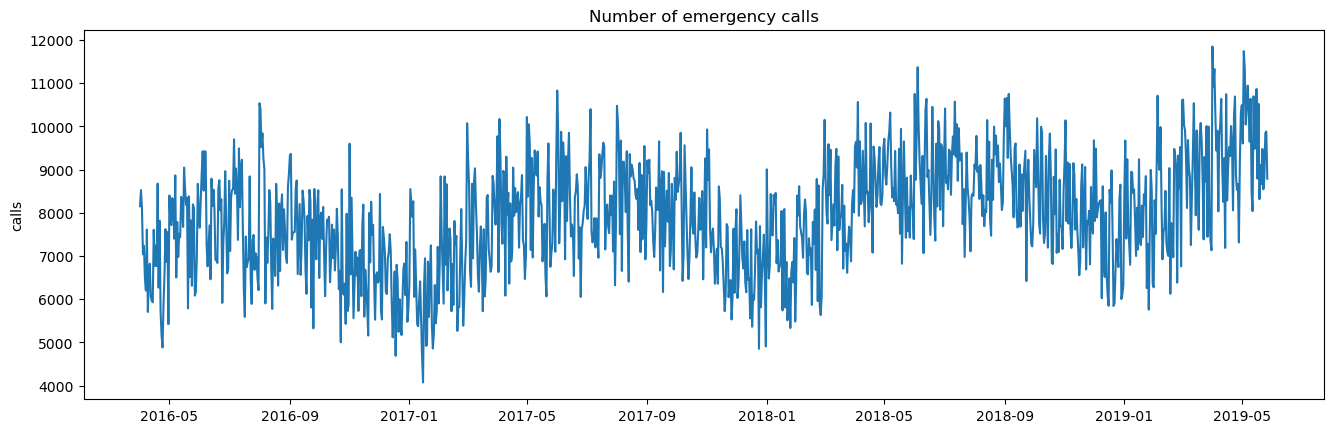

In [1020]:
# Create a figure
fig, ax = plt.subplots()
# Set figure width [inch]
fig.set_figwidth(16)
# Plot data
ax.plot(data.date, data.calls)
# Set y-label
ax.set_ylabel("calls")
# Set title
ax.set_title("Number of emergency calls")

### n_sick

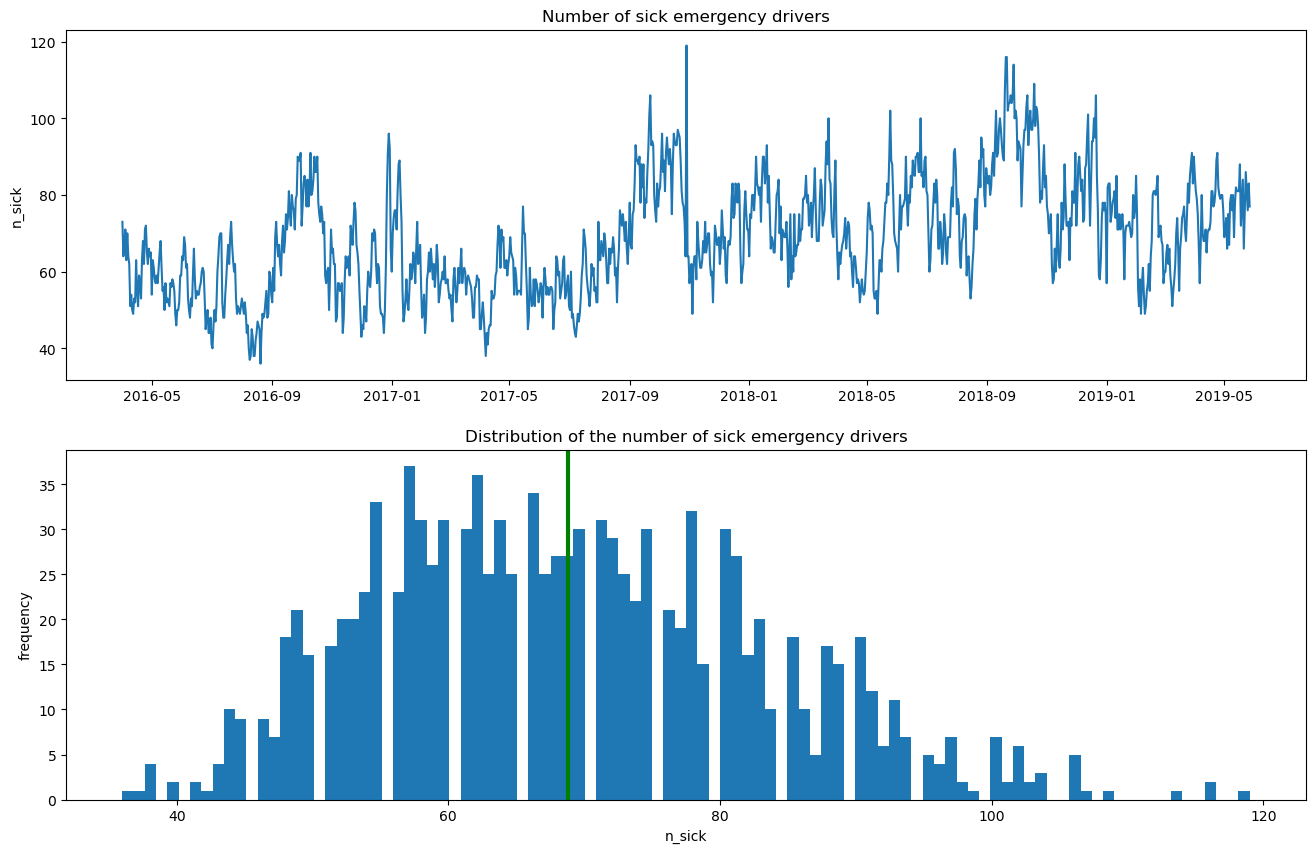

In [1021]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)
# Set figure width and height[inch]
fig.set_figwidth(16)
fig.set_figheight(10)

# Plot data
ax1.plot(data.date, data.n_sick)
# Set y-label
ax1.set_ylabel("n_sick")
# Set title
ax1.set_title("Number of sick emergency drivers")
# Plot data: The distribution of n_sick
# Number of equal-width bins in the range
nbins = 100
n, bins, patches = ax2.hist(data.n_sick, bins=nbins)
# Set x-label
ax2.set_xlabel("n_sick")
# Set y-label
ax2.set_ylabel("frequency")
# Set title
ax2.set_title("Distribution of the number of sick emergency drivers")
# A green vertical line at the average
ax2.axvline(x=data.n_sick.mean(), linewidth=3, color = 'g')


### Descriptive Statistics

Checking the data after cleansing unsing descriptive statistics (Mukhiya & Ahmed, 2020, p. 76).

#### Information about the DataFrame

In [1022]:
# Print some information about the DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   date      1152 non-null   datetime64[ns, UTC]
 1   n_sick    1152 non-null   int64              
 2   calls     1152 non-null   float64            
 3   n_duty    1152 non-null   int64              
 4   n_sby     1152 non-null   int64              
 5   sby_need  1152 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(3)
memory usage: 54.1 KB
None


#### Analyze the DataFrame

(Mukhiya & Ahmed, 2020, p. 145-158)

In [1023]:
data.describe()

,n_sick,calls,n_duty,n_sby,sby_need
count,1152.000000,1152.000000,1152.000000,1152.0,1152.000000
mean,68.808160,7919.531250,1820.572917,90.0,34.718750
std,14.293942,1290.063571,80.086953,0.0,79.694251
min,36.000000,4074.000000,1700.000000,90.0,0.000000
25%,58.000000,6978.000000,1800.000000,90.0,0.000000
50%,68.000000,7932.000000,1800.000000,90.0,0.000000
75%,78.000000,8827.500000,1900.000000,90.0,12.250000
max,119.000000,11850.000000,1900.000000,90.0,555.000000


## Outlier detection and filtering

(Mukhiya & Ahmed, 2020, p. 126)

# Time Series Analysis

(Mukhiya & Ahmed, 2020, p. 215)